# The Evolution of Popular Music over Recent Years
### By Noah Griff, Timmy Trapaidze, and Christian Tonti
![Billboard Hot 100 1988](https://media.npr.org/assets/img/2013/08/01/1988---billboard-hot-100-singles-chart_wide-1181692be74853bd0bf8fa888ae2733ae79ac585.jpg?s=1400)
## Table of Contents
1. [Introduction](#introduction)
    - [Useful Resources](#resources)


## Introduction<a name='introduction'></a>
Over the years, music has become an increasingly large part of our daily lives. With each technological development, from public radio and cassette tapes to music streaming services and fully wireless earbuds, we have had more and more ways to listen to the songs we love. While a form of cultural and personal expression, popular music also provides a common ground on which people can connect. When a song comes on at an event or party that everybody knows the words to, people sing along, have fun, and have a great time. So we started thinking: while music-listening technology has changed over the years, how has what the general population considers enjoyable evolved? What attributes of a song make it popular, and is it that different a couple decades ago?  
  
Luckily for us, a company has been keeping track of the most popular songs since the latter half of the 20th century. Starting in August of 1958, Billboard has been publishing the Hot 100 songs every week, year and decade, allowing us to get a snapshot of what popular music has looked like over time.  
  
In this project, we will be using Billboard's yearly Hot 100 charts from 1975 to present along with Spotify's Web API in order to conduct analysis on the evolution of popular music in recent years. Spotify's API has an endpoint called audio-analysis, which returns analytical information about a song, such as its tempo, key, danceability, and energy. Using all of this information, we will analyze if any of these features have changed over time, as well as if there is a correlation between them and the song's rank within the chart.

### Useful Resources<a name='resources'></a>
Here is a list of some useful, helpful, or interesting resources related to our work:
- [The creation, rise, and rule of Billboard's Hot 100 - NPR](https://www.npr.org/sections/therecord/2013/08/16/207879695/how-the-hot-100-became-americas-hit-barometer)
- [Why music is getting louder - Curiosity.com](https://curiosity.com/topics/why-music-is-getting-louder-curiosity/)
- [Research paper on the evolution of popular music](https://doi.org/10.1098/rsos.150081)
- [Spotify Web API Reference](https://developer.spotify.com/documentation/web-api/reference/)
    - [Audio analysis endpoint](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)
--------
For this project, we will be using Python 3 along with the following libraries:
- [spotipy](https://spotipy.readthedocs.io/en/latest/#) to efficiently query the Spotify Web API with Python
- [urllib.request](https://docs.python.org/3/library/urllib.request.html) to get the HTML from the websites which have the Billboard Hot 100 charts
- [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to help us scrape the Billboard Hot 100 charts by reading through and analyzing the HTML files
- [pandas](https://pandas.pydata.org/pandas-docs/stable/) to store, organize, and manipulate all of our data using powerful DataFrame objects
- [numpy](https://docs.scipy.org/doc/numpy/reference/index.html) to add NaN values as well as some extra functions
- [seaborn](https://seaborn.pydata.org/) to easily and beautifully visualize our findings
- [matplotlib.pyplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html) to further manipulate the appearance of our graphs
  
We begin by importing these libraries here:

In [2]:
# install spotipy if not installed
!pip install spotipy
# imports
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import time

In [19]:
song = []
rank = []
year = []
artist = []




page = Request("https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970",headers={'User-Agent': 'Mozilla/5.0'})
html = urlopen(page).read()
wiki = pd.read_html(html)[0]


for i in range(1971,2020):
    
    #2012 and 2013 just did not want to be scrapable
    if(i != 2012 and i != 2013):
        year = [i] * 100
        page = Request("https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_"+str(i),headers={'User-Agent': 'Mozilla/5.0'})
        html = urlopen(page).read()
        cur = pd.read_html(html)[0]
        cur['year'] = year
        wiki = wiki.append(cur,ignore_index=True)

1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2014
2015
2016
2017
2018
2019


In [13]:
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 7 columns):
0            0 non-null float64
1            1 non-null object
Artist(s)    4700 non-null object
No.          3200 non-null float64
Title        4700 non-null object
year         4700 non-null float64
№            1500 non-null float64
dtypes: float64(4), object(3)
memory usage: 257.2+ KB


In [20]:

rank = []

wiki = wiki.fillna(0)

for i,row in wiki.iterrows():
    no = row['№']
    num = row['No.']
    
        
    rank.append(no + num)



wiki['rank'] = rank
wiki = wiki.drop(columns=['No.','№'])
wiki['year'] = wiki['year'].replace(0.0,1992)
wiki['year'] = wiki['year'].astype('int64')
wiki['rank'] = wiki['rank'].astype('int64')

wiki = wiki.rename(columns={"Artist(s)": "artist", "Title":"song"})
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 6 columns):
0         4701 non-null float64
1         4701 non-null object
artist    4701 non-null object
song      4701 non-null object
year      4701 non-null int64
rank      4701 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 220.5+ KB


In [21]:
wiki = wiki.drop(columns=[0,1], axis = 1)
wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 4 columns):
artist    4701 non-null object
song      4701 non-null object
year      4701 non-null int64
rank      4701 non-null int64
dtypes: int64(2), object(2)
memory usage: 147.0+ KB


In [23]:
data = wiki.loc[wiki['year'] > 1970]
data

,artist,song,year,rank
0,0,0,1992,0
1,Three Dog Night,"""Joy to the World""",1971,1
2,Rod Stewart,"""Maggie May""/""Reason to Believe""",1971,2
3,Carole King,"""It's Too Late""/""I Feel the Earth Move""",1971,3
4,The Osmonds,"""One Bad Apple""",1971,4
5,Bee Gees,"""How Can You Mend a Broken Heart""",1971,5
6,Paul Revere & the Raiders,"""Indian Reservation (The Lament of the Cheroke...",1971,6
7,Donny Osmond,"""Go Away Little Girl""",1971,7
8,John Denver,"""Take Me Home, Country Roads""",1971,8
9,The Temptations,"""Just My Imagination (Running Away with Me)""",1971,9


In [24]:
SPOTIPY_CLIENT_ID='dfc90bae743943689c070c2f0b7fd7e0'
SPOTIPY_CLIENT_SECRET='477f42668a624f6e875a5399643b8c00'

# passes in the credentials for the cleint credential flow
client_credentials_manager = SpotifyClientCredentials(SPOTIPY_CLIENT_ID,SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

results = []

for index, row in data.iterrows():
    results.append(sp.search(q=row.song,type='track'))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
retrying ...1secs
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700


In [25]:
index = 0
analyses = []
for result in results:
    # if the items key doesnt exist, bad data -- drop row and continue to next row
    if 'items' in result['tracks']:     
        # if the dictionary length is 0, drop row and continue
        if len(result['tracks']['items']) > 0:
            # search for audio features of current song. pull the first result 
            analysis = sp.audio_features(result['tracks']['items'][0]['id'])
            analyses.append(analysis)
        else:
            data.drop(index, inplace=True)
            continue
    else:
        data.drop(index, inplace=True)
        continue
        
    index += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600


In [26]:
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = [] 
valence = [] 
tempo = [] 
type_feature = [] 
song_id = []
uri = []
track_href = []
analysis_url = []
duration_ms = []
time_signature = []
name = []

index = 0

for analysis in analyses:
    # the audio features method returned a none type, drop the row
    if analysis[0] is None:
        data.drop(index, inplace=True)
    else:
        name.append(row.song)
        danceability.append(analysis[0]['danceability'])
        energy.append(analysis[0]['energy'])
        key.append(analysis[0]['key'])
        loudness.append(analysis[0]['loudness'])
        mode.append(analysis[0]['mode'])
        speechiness.append(analysis[0]['speechiness'])
        acousticness.append(analysis[0]['acousticness'])
        instrumentalness.append(analysis[0]['instrumentalness'])
        liveness.append(analysis[0]['liveness'])
        valence.append(analysis[0]['valence'])
        tempo.append(analysis[0]['tempo'])
        type_feature.append(analysis[0]['type'])
        song_id.append(analysis[0]['id'])
        uri.append(analysis[0]['uri'])
        track_href.append(analysis[0]['track_href'])
        analysis_url.append(analysis[0]['analysis_url'])
        duration_ms.append(analysis[0]['duration_ms'])
        time_signature.append(analysis[0]['time_signature'])
        
    index += 1
    
data['danceability'] = danceability
data['energy'] = energy
data['key'] = key
data['loudness'] = loudness
data['mode'] = mode
data['speechiness'] = speechiness
data['acousticness'] = acousticness
data['instrumentalness'] = instrumentalness
data['liveness'] = liveness
data['valence'] = valence
data['tempo'] = tempo
data['type_feature'] = type_feature
data['song_id'] = song_id
data['uri'] = uri
data['track_href'] = track_href
data['analysis_url'] = analysis_url
data['duration_ms'] = duration_ms
data['time_signature'] = time_signature

data

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154


,artist,song,year,rank,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type_feature,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0,1992,0,0.559,0.716,11,-3.964,0,0.3900,...,0.2520,0.504,176.618,audio_features,4jtyUzZm9WLc2AdaJ1dso7,spotify:track:4jtyUzZm9WLc2AdaJ1dso7,https://api.spotify.com/v1/tracks/4jtyUzZm9WLc...,https://api.spotify.com/v1/audio-analysis/4jty...,275227,4
1,Three Dog Night,"""Joy to the World""",1971,1,0.553,0.337,10,-10.334,1,0.0300,...,0.1130,0.662,101.918,audio_features,1VuAamHM7P3VQQEXYGG3Uu,spotify:track:1VuAamHM7P3VQQEXYGG3Uu,https://api.spotify.com/v1/tracks/1VuAamHM7P3V...,https://api.spotify.com/v1/audio-analysis/1VuA...,84987,4
2,Rod Stewart,"""Maggie May""/""Reason to Believe""",1971,2,0.566,0.585,2,-8.733,1,0.0362,...,0.0911,0.567,129.475,audio_features,7hBTWJwdCkZt7IjUsENqmv,spotify:track:7hBTWJwdCkZt7IjUsENqmv,https://api.spotify.com/v1/tracks/7hBTWJwdCkZt...,https://api.spotify.com/v1/audio-analysis/7hBT...,350147,4
4,The Osmonds,"""One Bad Apple""",1971,4,0.600,0.567,0,-7.163,1,0.0398,...,0.2130,0.920,101.041,audio_features,50UoJUrslRVqG0cg6uboyn,spotify:track:50UoJUrslRVqG0cg6uboyn,https://api.spotify.com/v1/tracks/50UoJUrslRVq...,https://api.spotify.com/v1/audio-analysis/50Uo...,164973,4
5,Bee Gees,"""How Can You Mend a Broken Heart""",1971,5,0.458,0.421,4,-6.960,1,0.0403,...,0.0705,0.368,146.598,audio_features,6lUXneXZ9jc3HSMHgd8oqh,spotify:track:6lUXneXZ9jc3HSMHgd8oqh,https://api.spotify.com/v1/tracks/6lUXneXZ9jc3...,https://api.spotify.com/v1/audio-analysis/6lUX...,383503,3
6,Paul Revere & the Raiders,"""Indian Reservation (The Lament of the Cheroke...",1971,6,0.639,0.385,2,-13.253,1,0.0759,...,0.0873,0.209,131.714,audio_features,3mDOHVY9MWZOTODSNF5GBj,spotify:track:3mDOHVY9MWZOTODSNF5GBj,https://api.spotify.com/v1/tracks/3mDOHVY9MWZO...,https://api.spotify.com/v1/audio-analysis/3mDO...,171933,4
7,Donny Osmond,"""Go Away Little Girl""",1971,7,0.418,0.294,0,-14.145,1,0.0316,...,0.2250,0.557,108.613,audio_features,4aSc9ICb487a9JjGXSMDMk,spotify:track:4aSc9ICb487a9JjGXSMDMk,https://api.spotify.com/v1/tracks/4aSc9ICb487a...,https://api.spotify.com/v1/audio-analysis/4aSc...,132093,4
8,John Denver,"""Take Me Home, Country Roads""",1971,8,0.255,0.430,9,-12.564,1,0.0322,...,0.1880,0.546,164.267,audio_features,39q7xibBdRboeMKUbZEB6g,spotify:track:39q7xibBdRboeMKUbZEB6g,https://api.spotify.com/v1/tracks/39q7xibBdRbo...,https://api.spotify.com/v1/audio-analysis/39q7...,197813,4
9,The Temptations,"""Just My Imagination (Running Away with Me)""",1971,9,0.425,0.242,0,-15.424,1,0.0267,...,0.1950,0.477,92.472,audio_features,39Bd345OWEhRNyfayhp9gv,spotify:track:39Bd345OWEhRNyfayhp9gv,https://api.spotify.com/v1/tracks/39Bd345OWEhR...,https://api.spotify.com/v1/audio-analysis/39Bd...,228160,4
10,Tony Orlando and Dawn,"""Knock Three Times""",1971,10,0.777,0.581,1,-10.129,1,0.0517,...,0.1100,0.930,123.100,audio_features,6gvfXd7pEUSPuNEMWwOJUH,spotify:track:6gvfXd7pEUSPuNEMWwOJUH,https://api.spotify.com/v1/tracks/6gvfXd7pEUSP...,https://api.spotify.com/v1/audio-analysis/6gvf...,180360,4


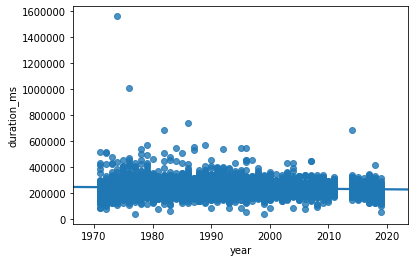

In [28]:
sns.regplot(x=data['year'],y=data['duration_ms'])

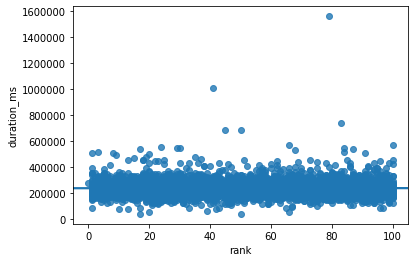

In [29]:
sns.regplot(x=data['rank'],y=data['duration_ms'])

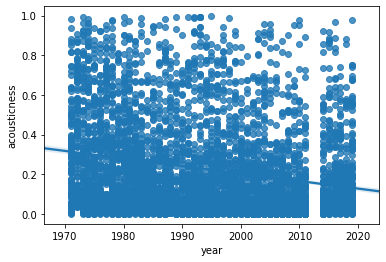

In [30]:
sns.regplot(x=data['year'],y=data['acousticness'])

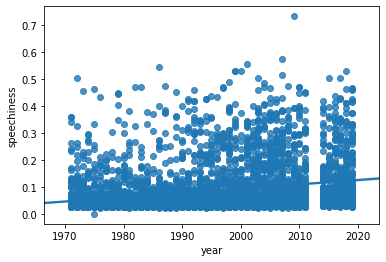

In [31]:
sns.regplot(x=data['year'],y=data['speechiness'])

In [140]:
grouped = data.groupby('year',as_index = False).mean()
grouped.head()


,year,level_0,index,rank,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1971,49.5,50.897959,50.897959,0.585490,0.585415,4.806122,-9.695684,0.714286,0.064344,0.331709,0.035202,0.156188,0.656673,116.031173,206402.479592,3.94898
1,1972,148.5,150.500000,50.500000,0.587790,0.548344,5.200000,-9.702650,0.740000,0.066357,0.401229,0.038205,0.182693,0.627022,121.754910,216849.780000,3.94000
2,1973,248.5,250.500000,50.500000,0.600591,0.576703,5.280000,-10.017580,0.700000,0.061200,0.343584,0.057322,0.174489,0.676807,121.062880,230446.630000,3.95000
3,1974,348.5,350.500000,50.500000,0.590440,0.592520,5.120000,-9.448450,0.840000,0.062311,0.348638,0.016502,0.196056,0.602765,116.841010,237010.140000,3.90000
4,1975,448.5,450.500000,50.500000,0.603960,0.581232,5.250000,-9.640760,0.800000,0.059444,0.306142,0.032832,0.196938,0.622714,113.894580,230268.580000,3.92000


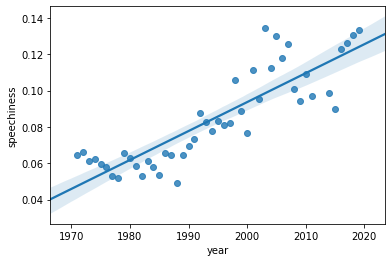

In [33]:

sns.regplot(x=grouped['year'] , y = grouped['speechiness'])

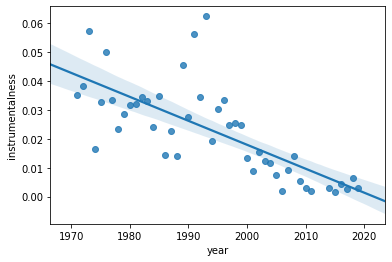

In [34]:
sns.regplot(x=grouped['year'], y= grouped['instrumentalness'])

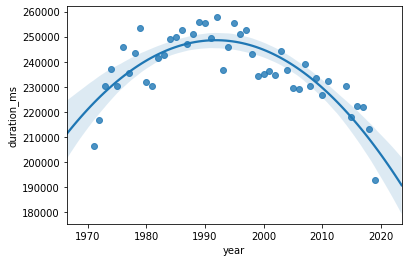

In [138]:
# The average length of a top 100 song has decreased by about 30 seconds from about 4 minutes to about 3 and a half minutes
sns.regplot(x=grouped['year'], y = grouped['duration_ms'],order=2)

In [145]:
nines = data.loc[data['year'] < 1996]
nines = nines.loc[nines['year'] >= 1990]
nines = nines.loc[nines['rank'] == 1]
nines.head()

,level_0,index,artist,song,year,rank,danceability,energy,key,loudness,...,liveness,valence,tempo,type_feature,song_id,uri,track_href,analysis_url,duration_ms,time_signature
1898,1898,1901,Wilson Phillips,"""Hold On""",1990,1,0.691,0.602,9,-6.807,...,0.0637,0.685,151.987,audio_features,5qDsijQM75KTdv3RtSPx91,spotify:track:5qDsijQM75KTdv3RtSPx91,https://api.spotify.com/v1/tracks/5qDsijQM75KT...,https://api.spotify.com/v1/audio-analysis/5qDs...,189480,4
1998,1998,2001,Bryan Adams,"""(Everything I Do) I Do It for You""",1991,1,0.526,0.365,1,-12.605,...,0.0618,0.253,131.253,audio_features,6eBK3edMW7bEzecF1eCezc,spotify:track:6eBK3edMW7bEzecF1eCezc,https://api.spotify.com/v1/tracks/6eBK3edMW7bE...,https://api.spotify.com/v1/audio-analysis/6eBK...,394133,4
2098,2098,2101,Boyz II Men,"""End of the Road""",1992,1,0.373,0.717,1,-5.833,...,0.1140,0.293,109.977,audio_features,24BNgrtp6Fag4M5BQPEgsV,spotify:track:24BNgrtp6Fag4M5BQPEgsV,https://api.spotify.com/v1/tracks/24BNgrtp6Fag...,https://api.spotify.com/v1/audio-analysis/24BN...,162981,5
2198,2198,2201,Whitney Houston,"""I Will Always Love You""",1993,1,0.306,0.214,4,-12.518,...,0.0839,0.108,66.980,audio_features,4eHbdreAnSOrDDsFfc4Fpm,spotify:track:4eHbdreAnSOrDDsFfc4Fpm,https://api.spotify.com/v1/tracks/4eHbdreAnSOr...,https://api.spotify.com/v1/audio-analysis/4eHb...,271093,4
2298,2298,2301,Ace of Base,"""The Sign""",1994,1,0.516,0.595,5,-4.630,...,0.1090,0.222,119.972,audio_features,5Ohxk2dO5COHF1krpoPigN,spotify:track:5Ohxk2dO5COHF1krpoPigN,https://api.spotify.com/v1/tracks/5Ohxk2dO5COH...,https://api.spotify.com/v1/audio-analysis/5Ohx...,340707,4


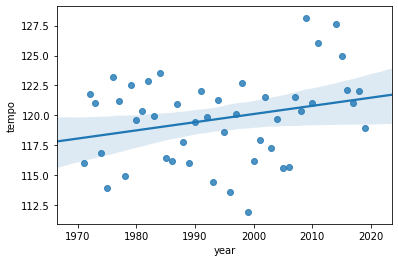

In [36]:
sns.regplot(x=grouped['year'], y = grouped['tempo'])

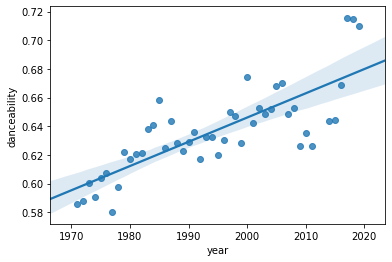

In [37]:
# Songs Have been getting more dancable
sns.regplot(x=grouped['year'], y = grouped['danceability'])

In [38]:
byRank = data.groupby('rank',as_index=False).mean()
byRank.head()

,rank,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,1992.000000,0.559000,0.716000,11.000000,-3.964000,0.000000,0.390000,0.737000,0.000000,0.252000,0.504000,176.618000,275227.000000,4.000000
1,1,1994.255319,0.636660,0.592413,4.659574,-8.220851,0.787234,0.082506,0.251095,0.013259,0.171183,0.569064,117.741021,237233.446809,3.936170
2,2,1994.255319,0.691660,0.630283,4.638298,-7.194468,0.680851,0.067032,0.249328,0.039124,0.130757,0.636319,122.002021,239067.148936,4.000000
3,3,1994.760870,0.657630,0.610543,5.021739,-7.753217,0.673913,0.052865,0.249867,0.017879,0.167448,0.579950,113.712783,243252.565217,3.847826
4,4,1994.255319,0.666574,0.602787,4.191489,-7.992702,0.702128,0.069874,0.274134,0.030699,0.153017,0.565532,123.172638,236294.744681,3.936170


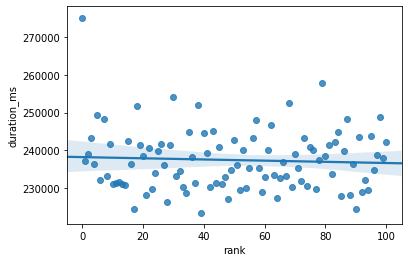

In [39]:
sns.regplot(byRank['rank'],byRank['duration_ms'])

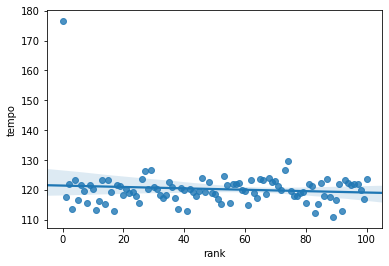

In [40]:
sns.regplot(byRank['rank'],byRank['tempo'])

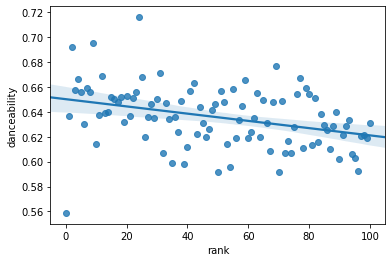

In [41]:
# Songs have been getting slowly less danceable
sns.regplot(byRank['rank'],byRank['danceability'])

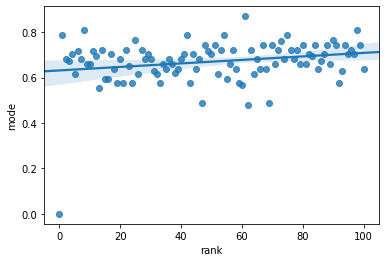

In [42]:
sns.regplot(byRank['rank'],byRank['mode'])

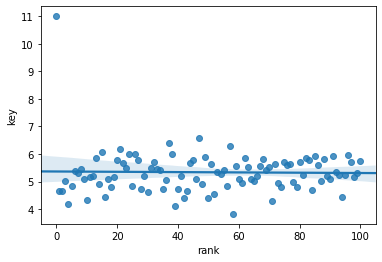

In [43]:
sns.regplot(byRank['rank'],byRank['key'])

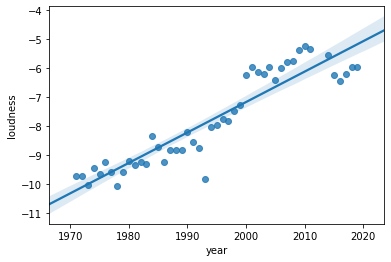

In [44]:
'''
Songs have been getting louder
https://curiosity.com/topics/why-music-is-getting-louder-curiosity/
'''

sns.regplot(grouped['year'],grouped['loudness'])

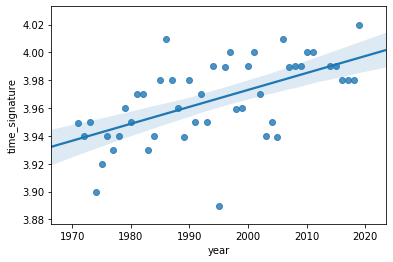

In [45]:
sns.regplot(grouped['year'],grouped['time_signature'])

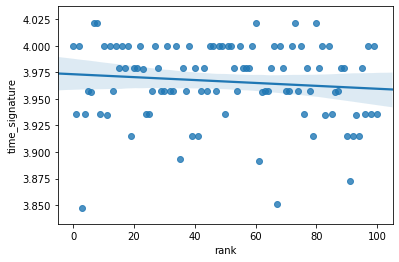

In [46]:
sns.regplot(byRank['rank'],byRank['time_signature'])

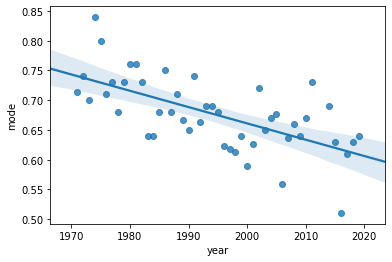

In [47]:
# Over the years a song is more likely to be minor
sns.regplot(grouped['year'],grouped['mode'])

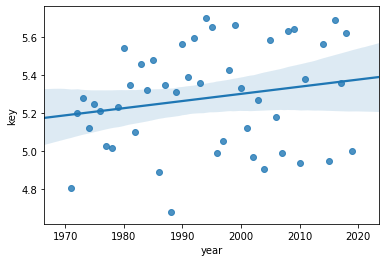

In [48]:
sns.regplot(grouped['year'],grouped['key'])

<h1><center>The Titans of Popular Music</center></h1>

In [149]:

data.head()
topArt = data['artist'].value_counts().to_frame(name='Num_Songs')
topArt = topArt.loc[topArt['Num_Songs'] > 9]
artID = []
genres = []
for i,row in topArt.iterrows():
    result = sp.search(q=i,type='artist')
    artID.append(result['artists']['items'][0]['id'])
    genres.append(result['artists']['items'][0]['genres'])

In [150]:

topArt['artID'] = artID
topArt['genres'] = genres

topArt

,Num_Songs,artID,genres
Madonna,35,6tbjWDEIzxoDsBA1FuhfPW,"[dance pop, pop]"
Elton John,26,3PhoLpVuITZKcymswpck5b,"[glam rock, mellow gold, piano rock]"
Mariah Carey,24,4iHNK0tOyZPYnBU7nGAgpQ,"[dance pop, pop, r&b, urban contemporary]"
Janet Jackson,23,4qwGe91Bz9K2T8jXTZ815W,"[dance pop, hip pop, neo soul, new jack swing,..."
Michael Jackson,22,3fMbdgg4jU18AjLCKBhRSm,"[pop, r&b, soul]"
Taylor Swift,20,06HL4z0CvFAxyc27GXpf02,"[pop, post-teen pop]"
Whitney Houston,19,6XpaIBNiVzIetEPCWDvAFP,"[dance pop, pop, r&b]"
Pink,18,0k17h0D3J5VfsdmQ1iZtE9,"[album rock, art rock, classic rock, progressi..."
Stevie Wonder,17,7guDJrEfX3qb6FEbdPA5qi,"[adult standards, motown, quiet storm, soul]"
Hall & Oates,17,77tT1kLj6mCWtFNqiOmP9H,"[album rock, classic rock, mellow gold, rock, ..."


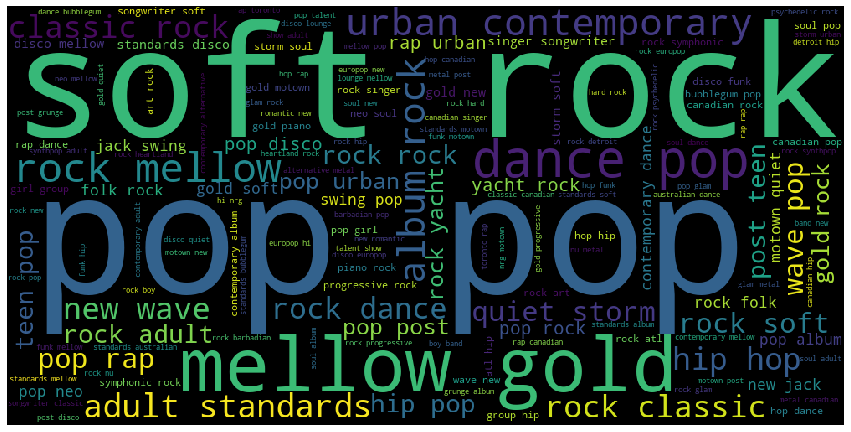

In [156]:

topGen = []

for i,row in topArt.iterrows():
    curGen = topArt['genres']
    for cgen in curGen:
        for gen in cgen:
            topGen.append(gen)
        
unique_string=(" ").join(topGen)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()
        


In [79]:
topSongs = []

for i,row in topArt.iterrows():
    curArt = i
    for j,s in data.iterrows():
        if(s['artist'] == curArt):
            topSongs.append(s)
#             print(s['song'])
            
    

In [87]:
songs = pd.DataFrame(topSongs)
songs = songs.drop(columns=['level_0','index'])
songs = songs.reset_index()
songs = songs.drop('index',axis = 1)


,artist,song,year,rank,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type_feature,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,Madonna,"""Borderline""",1984,35,0.5980,0.71000,0,-6.839,0,0.0272,...,0.1000,0.72600,97.976,audio_features,3O8X1DE9btbzy4UH9cSX9a,spotify:track:3O8X1DE9btbzy4UH9cSX9a,https://api.spotify.com/v1/tracks/3O8X1DE9btbz...,https://api.spotify.com/v1/audio-analysis/3O8X...,274294,4
1,Madonna,"""Lucky Star""",1984,66,0.7930,0.62700,4,-10.599,0,0.0431,...,0.1450,0.96300,117.203,audio_features,2hWI9GNr3kBrxZ7Mphho4Q,spotify:track:2hWI9GNr3kBrxZ7Mphho4Q,https://api.spotify.com/v1/tracks/2hWI9GNr3kBr...,https://api.spotify.com/v1/audio-analysis/2hWI...,333773,4
2,Madonna,"""Holiday""",1984,79,0.3170,0.15800,9,-16.485,1,0.0381,...,0.3380,0.24700,130.503,audio_features,4so0Wek9Ig1p6CRCHuINwW,spotify:track:4so0Wek9Ig1p6CRCHuINwW,https://api.spotify.com/v1/tracks/4so0Wek9Ig1p...,https://api.spotify.com/v1/audio-analysis/4so0...,177480,3
3,Madonna,"""Like a Virgin""",1985,2,0.7730,0.65600,3,-10.880,0,0.0381,...,0.0697,0.97100,119.754,audio_features,1ZPlNanZsJSPK5h9YZZFbZ,spotify:track:1ZPlNanZsJSPK5h9YZZFbZ,https://api.spotify.com/v1/tracks/1ZPlNanZsJSP...,https://api.spotify.com/v1/audio-analysis/1ZPl...,218627,4
4,Madonna,"""Crazy for You""",1985,9,0.7030,0.14200,7,-12.280,1,0.0498,...,0.1050,0.32400,85.857,audio_features,5zgVmAAZDu2VuJdLIYTAVH,spotify:track:5zgVmAAZDu2VuJdLIYTAVH,https://api.spotify.com/v1/tracks/5zgVmAAZDu2V...,https://api.spotify.com/v1/audio-analysis/5zgV...,208040,3
5,Madonna,"""Material Girl""",1985,58,0.7420,0.88300,0,-3.419,1,0.0329,...,0.0964,0.97800,136.506,audio_features,22sLuJYcvZOSoLLRYev1s5,spotify:track:22sLuJYcvZOSoLLRYev1s5,https://api.spotify.com/v1/tracks/22sLuJYcvZOS...,https://api.spotify.com/v1/audio-analysis/22sL...,240280,4
6,Madonna,"""Angel""",1985,81,0.6440,0.75500,1,-5.325,1,0.0448,...,0.0859,0.33400,102.861,audio_features,6zegtH6XXd2PDPLvy1Y0n2,spotify:track:6zegtH6XXd2PDPLvy1Y0n2,https://api.spotify.com/v1/tracks/6zegtH6XXd2P...,https://api.spotify.com/v1/audio-analysis/6zeg...,190067,4
7,Madonna,"""Dress You Up""",1985,98,0.6340,0.89600,0,-3.073,0,0.0318,...,0.1000,0.82700,136.098,audio_features,4B2r9HXgUqRcPwUG3BYPlc,spotify:track:4B2r9HXgUqRcPwUG3BYPlc,https://api.spotify.com/v1/tracks/4B2r9HXgUqRc...,https://api.spotify.com/v1/audio-analysis/4B2r...,242240,4
8,Madonna,"""Papa Don't Preach""",1986,29,0.8070,0.90600,5,-8.973,0,0.0371,...,0.0248,0.97100,121.540,audio_features,6A8OnjnpShshNpcqWtZRjr,spotify:track:6A8OnjnpShshNpcqWtZRjr,https://api.spotify.com/v1/tracks/6A8OnjnpShsh...,https://api.spotify.com/v1/audio-analysis/6A8O...,345280,4
9,Madonna,"""Live to Tell""",1986,35,0.6730,0.31400,2,-14.156,0,0.0279,...,0.1070,0.27000,109.841,audio_features,095MMFhB9qxPx2VsmvjnUs,spotify:track:095MMFhB9qxPx2VsmvjnUs,https://api.spotify.com/v1/tracks/095MMFhB9qxP...,https://api.spotify.com/v1/audio-analysis/095M...,353000,4


<h1><center>Madonna the leader of Billboards!</center></h1>

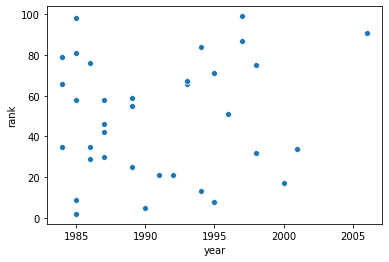

In [90]:
madonna = songs.loc[songs['artist'] == 'Madonna']
sns.scatterplot(madonna['year'],madonna['rank'])

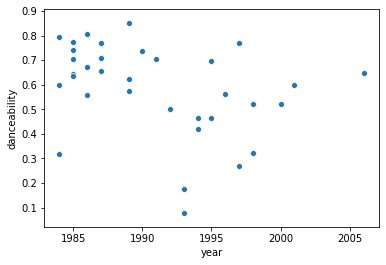

In [91]:
sns.scatterplot(madonna['year'],madonna['danceability'])

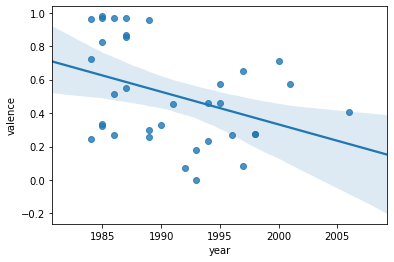

In [96]:
sns.regplot(madonna['year'],madonna['valence'])

# By Artist

In [134]:
byArtist = songs.groupby('artist').mean()
byArtist.head()

,year,rank,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
artist,,,,,,,,,,,,,,,
Aaliyah,1999.000000,61.636364,0.652091,0.651091,6.090909,-7.409727,0.545455,0.066727,0.256221,0.016004,0.179691,0.617909,113.504091,223407.727273,4.000000
Aerosmith,1990.250000,64.333333,0.519000,0.739167,4.916667,-6.158333,0.916667,0.045342,0.131327,0.010751,0.183417,0.455583,121.009000,255479.750000,4.000000
Alicia Keys,2005.900000,44.400000,0.569500,0.561900,4.700000,-7.813200,0.700000,0.089570,0.301280,0.025084,0.128330,0.339100,105.503600,265208.800000,4.000000
Barry Manilow,1977.454545,60.454545,0.360909,0.470727,3.818182,-8.803091,0.727273,0.035918,0.572182,0.004115,0.137255,0.325973,113.660000,247465.454545,3.909091
Bee Gees,1976.416667,30.083333,0.619917,0.587167,6.000000,-9.521667,0.500000,0.045708,0.190828,0.023787,0.246458,0.690333,113.605750,260175.000000,3.916667


# Who is the Saddest and Happiest Artist?

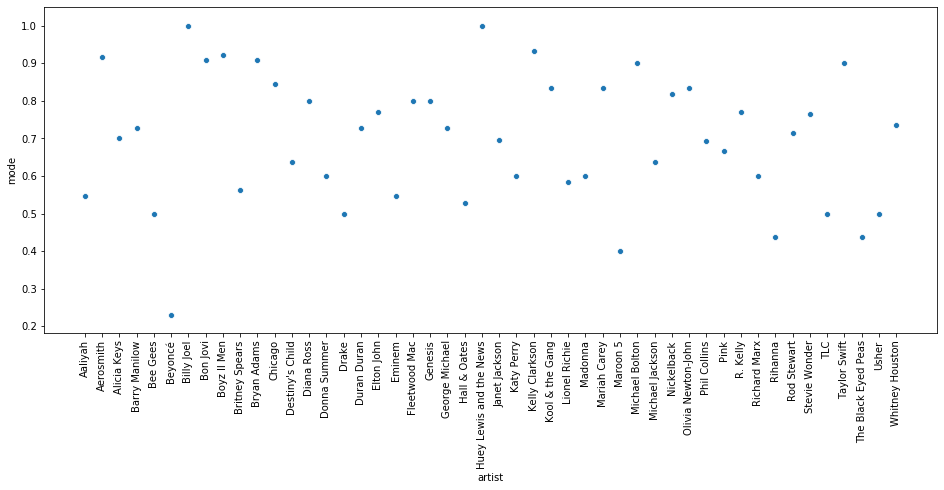

In [116]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90)
sns.scatterplot(byArtist.index,byArtist['mode'])

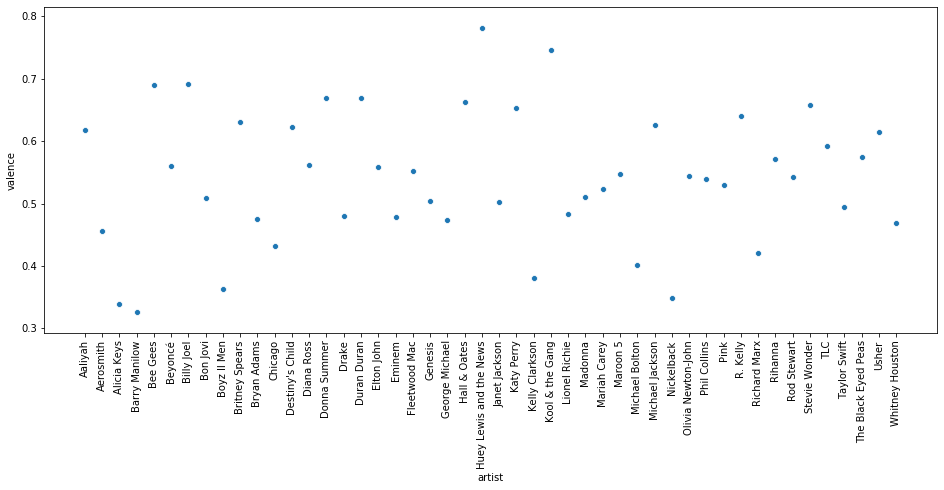

In [117]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90)
sns.scatterplot(byArtist.index,byArtist['valence'])

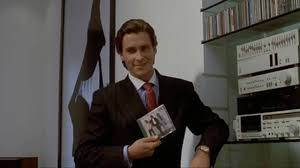

In [114]:
# Lets go Crazy
Image("huey.jpg")

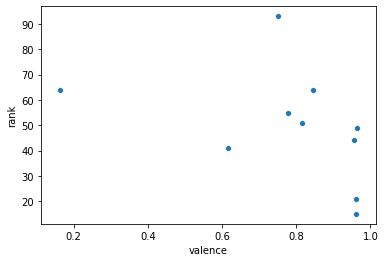

In [119]:
huey = songs.loc[songs['artist'] == 'Huey Lewis and the News']
sns.scatterplot(huey['valence'],huey['rank'])

On the other hand Alicia Keys, Barry Manilow, Boyz II Men, and Nickelback are all about producing sad hits. 

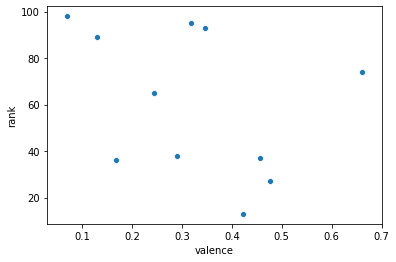

In [123]:
art = songs.loc[songs['artist'] == 'Barry Manilow']
sns.scatterplot(art['valence'],art['rank'])

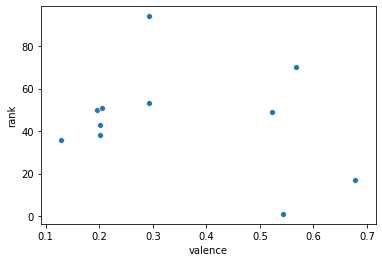

In [127]:
art = songs.loc[songs['artist'] == 'Nickelback']
sns.scatterplot(art['valence'],art['rank'])

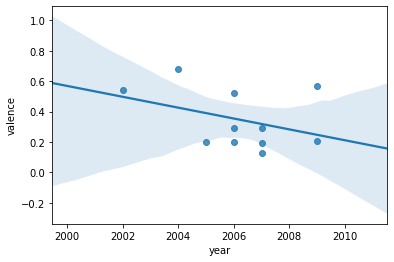

In [128]:
sns.regplot(art['year'],art['valence'])

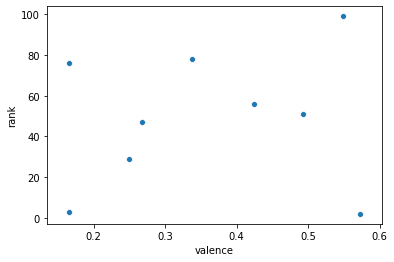

In [129]:
art = songs.loc[songs['artist'] == 'Alicia Keys']
sns.scatterplot(art['valence'],art['rank'])

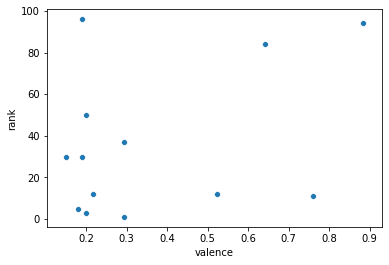

In [130]:
art = songs.loc[songs['artist'] == 'Boyz II Men']
sns.scatterplot(art['valence'],art['rank'])

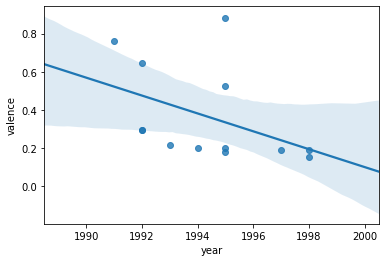

In [133]:
sns.regplot(art['year'],art['valence'])